# Import necessary libraries

In [1]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from IPython.display import VimeoVideo
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

#Load dataset

In [2]:
df = pd.read_csv("/content/drive/MyDrive/september_2018_sensor_data_archive.csv")
df.head()

,timestamp,P2
0,2018-09-01 00:00:26.722,19.30
1,2018-09-01 00:00:43.434,16.90
2,2018-09-01 00:01:19.344,16.10
3,2018-09-01 00:01:26.343,10.83
4,2018-09-01 00:01:29.906,18.47


#Prepare Data

In [3]:
def wrangle(df):
    # Convert the "timestamp" column to a DatetimeIndex
    df["timestamp"] = pd.to_datetime(df["timestamp"], infer_datetime_format=True)
    df.set_index("timestamp", inplace=True)

    # Localize timezone
    df.index = df.index.tz_localize("UTC").tz_convert("Africa/Nairobi")

    # Remove outliers
    df = df[df["P2"] < 500]

    # Resample to 1hr window
    y = df["P2"].resample("1H").mean().fillna(method='ffill')

    return y

In [4]:
# Use wrangle function to read the data
y = wrangle(df)
y.head()

timestamp
2018-09-01 03:00:00+03:00    15.858454
2018-09-01 04:00:00+03:00    13.275321
2018-09-01 05:00:00+03:00    11.583333
2018-09-01 06:00:00+03:00    11.627500
2018-09-01 07:00:00+03:00    13.981279
Freq: H, Name: P2, dtype: float64

#Explore

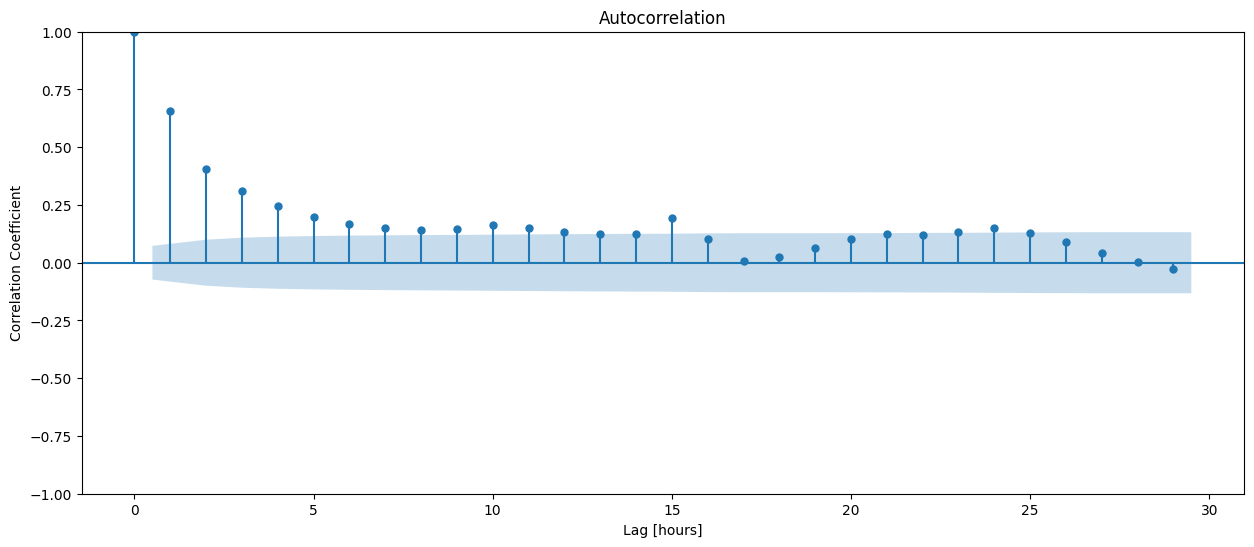

In [5]:
#Create an ACF plot for the data in y
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y,ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

As I move from left to right the lag gets bigger and bigger 
looking at acf plot I have alot of strong predicted power for first three or two hours ago.

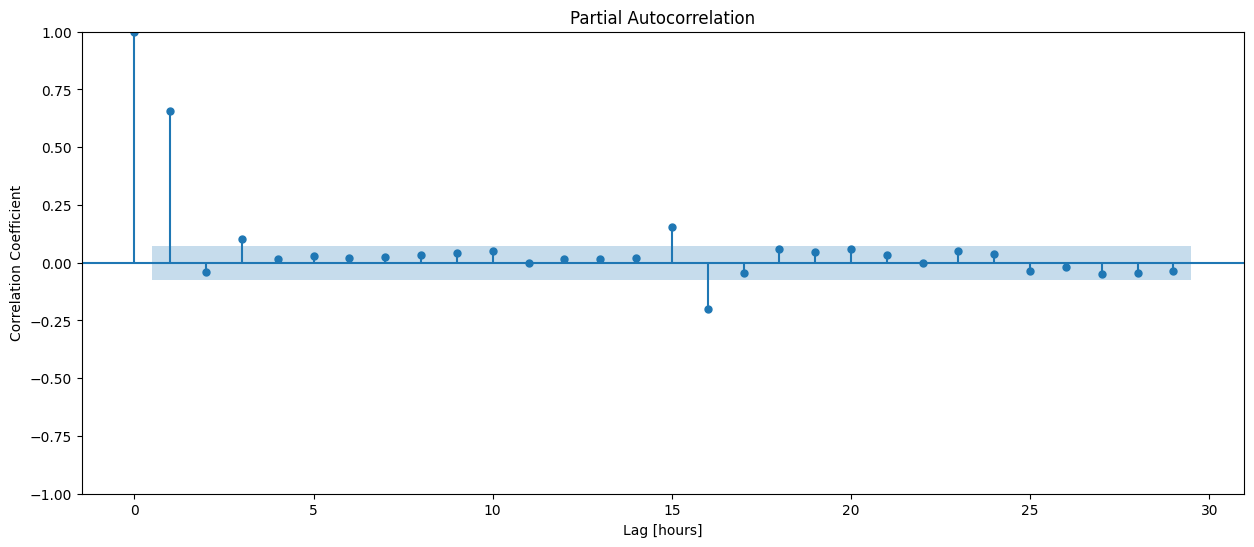

In [7]:
 #Create an PACF plot for the data in y
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y,ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

The above plot tells us beyond 26  hours back, we really don't have any predicted power.

# Split

In [8]:
# Split y into training and test sets. The first 95% of the data should be in your training set.
cutoff_test = int(len(y)*0.95)

y_train = y.iloc[:cutoff_test]
y_test = y.iloc[cutoff_test:]

In [9]:
len(y_train)+len(y_test)== len(y)

True

#Build Model

## Baseline

In [10]:
##Calculate the baseline mean absolute error for the model.
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean P2 Reading:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: 7.26
Baseline MAE: 3.08


##Iterate

In [11]:
#Instantiate an AutoReg model and fit it to the training data y_train
#set the lags argument to 26.
model = AutoReg(y_train,lags=26).fit()
# Generate a list of training predictions
y_pred = model.predict().dropna()
#Calculate the mean absolute error for a list of predictions
training_mae = mean_absolute_error(y_train.iloc[26:],y_pred)
print("Training MAE:", training_mae)

Training MAE: 1.8059275962071222


In [12]:
#calculate the residuals
y_train_resid = model.resid
y_train_resid.tail()

timestamp
2018-09-29 10:00:00+03:00   -0.119807
2018-09-29 11:00:00+03:00    2.912295
2018-09-29 12:00:00+03:00    1.907389
2018-09-29 13:00:00+03:00   -1.116214
2018-09-29 14:00:00+03:00   -1.481843
Freq: H, dtype: float64

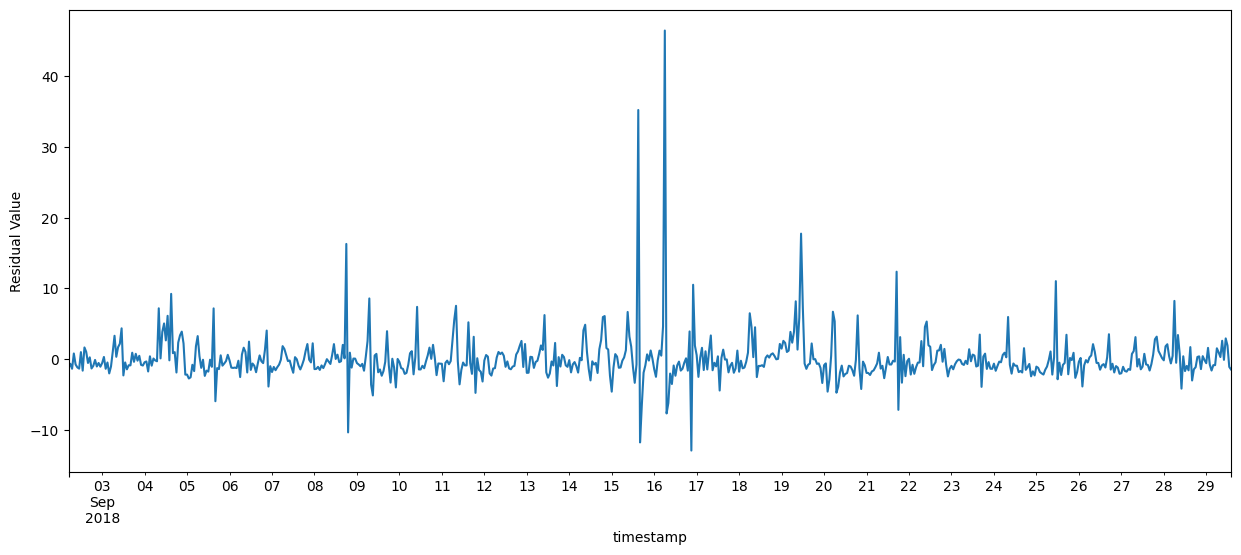

In [13]:
#Create a plot of y_train_resid
fig, ax = plt.subplots(figsize=(15, 6))
y_train_resid.plot(ylabel="Residual Value",ax =ax);

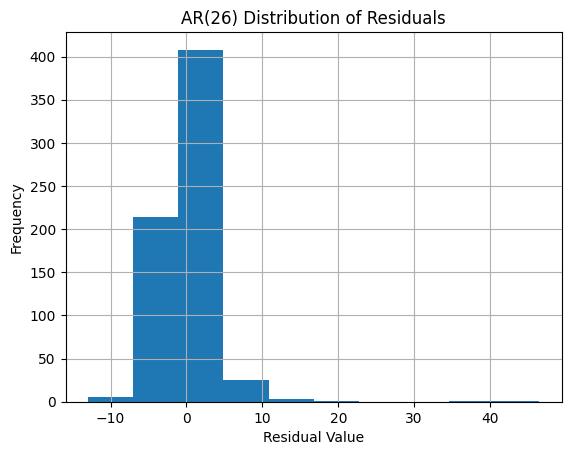

In [14]:
#Create a histogram of y_train_resid
y_train_resid.hist()
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.title("AR(26) Distribution of Residuals");

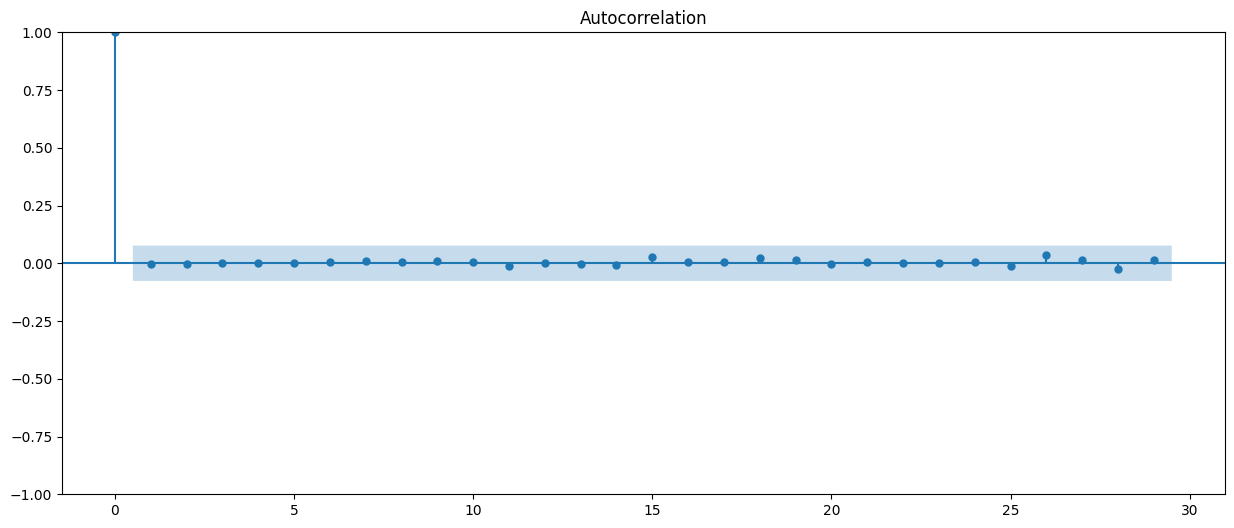

In [15]:
#Create an ACF plot of y_train_resid
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_train_resid,ax=ax);

#Evaluate
Calculate the test mean absolute error for the model.

In [16]:
y_pred_test = model.predict(y_test.index.min(),y_test.index.max())
test_mae = mean_absolute_error(y_test,y_pred_test)
print("Test MAE:", test_mae)

Test MAE: 1.2639528935600508


In [18]:
#Create a DataFrame test_predictions that has two columns: "y_test" and "y_pred"
df_pred_test = pd.DataFrame(
    {"y_test": y_test, "y_pred": y_pred_test}, index=y_test.index
)
df_pred_test.head()

,y_test,y_pred
timestamp,,
2018-09-29 15:00:00+03:00,7.305417,6.115246
2018-09-29 16:00:00+03:00,6.188611,6.768351
2018-09-29 17:00:00+03:00,6.246528,6.805365
2018-09-29 18:00:00+03:00,8.615753,6.631469
2018-09-29 19:00:00+03:00,10.954167,6.921125


In [19]:
# Create a time series plot for the values in test_predictions using plotly express
fig = px.line(df_pred_test, labels={"value": "P2"})
fig.show();

The model isn't functioning very well and that is because we can't use the traditional test set evaluation techniques when we're working with time series data. Instead I will use walk-forward validation.


In [22]:
# Perform walk-forward validation for my model for the entire test set y_test
y_pred_wfv = pd.Series(dtype='float64')
history = y_train.copy()
for i in range(len(y_test)):
    model = AutoReg(history, lags=26).fit()
    next_pred = model.forecast()
    y_pred_wfv = pd.concat([y_pred_wfv, next_pred])
    history = pd.concat([history, y_test[next_pred.index]])

In [24]:
test_mae = mean_absolute_error(y_test,y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 0.9


# Communicate Results

In [25]:
#Print out the parameters for the trained model.
print(model.params)

const     1.603682
P2.L1     0.684054
P2.L2    -0.114054
P2.L3     0.077737
P2.L4    -0.001909
P2.L5    -0.001892
P2.L6     0.002797
P2.L7     0.028640
P2.L8    -0.010404
P2.L9    -0.006657
P2.L10    0.050463
P2.L11   -0.011821
P2.L12   -0.007069
P2.L13    0.022848
P2.L14   -0.096591
P2.L15    0.269271
P2.L16   -0.159302
P2.L17   -0.084713
P2.L18    0.031533
P2.L19    0.005467
P2.L20    0.035045
P2.L21    0.038180
P2.L22   -0.029510
P2.L23    0.024673
P2.L24    0.061119
P2.L25   -0.021229
P2.L26   -0.016514
dtype: float64


In [26]:
#Put the values for y_test and y_pred_wfv into the DataFrame df_pred_test
df_pred_test= pd.DataFrame(
{
    "y_test":y_test,
     "y_pred_wfv":y_pred_wfv
    
}
)
fig = px.line(df_pred_test,labels={"value":"PM2.5"})
fig.show()